# BioPhy Technical Challenge

Ian Tong (Tom) Pan

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns                     
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from tpot import TPOTClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTETomek

C:\Users\tp36t\.conda\envs\cmapPy3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [21]:
df = pd.read_csv("BioPhy_CodingTest.csv")

First I want to do some exploratory data analysis to get a feel for the data and determine any potential transformations I may need to make

In [58]:
df.head()

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,id,lang,location,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,False,False,4,1589,4,False,7.870000e+17,en,unknown,11041,False,7.870,1403,bot
1,False,False,536,860,880,False,7.960000e+17,en,Estados Unidos,252,False,0.183,1379,human
2,False,False,3307,172,594,True,8.760000e+17,en,"Los Angeles, CA",1001,False,0.864,1159,human
3,True,False,8433,517,633,True,7.560000e+17,en,"Birmingham, AL",1324,False,0.889,1489,human
4,False,False,88,753678,116,True,4.647813e+08,en,"England, United Kingdom",4202,True,1.339,3138,human


In [59]:
df.dtypes

default_profile              bool
default_profile_image        bool
favorites_count             int64
followers_count             int64
friends_count               int64
geo_enabled                  bool
id                        float64
lang                       object
location                   object
statuses_count              int64
verified                     bool
average_tweets_per_day    float64
account_age_days            int64
account_type               object
dtype: object

Looking at the datatypes, we see a few strings (objects), which will probably require one-hot encoding to learn effectively on. Also I am going to convert the booleans into binary to avoid any issues that may arise with particular ML algorithms.

In [60]:
duplicates = df.duplicated()
print(pd.unique(duplicates))
print(len(duplicates[duplicates]))

[False  True]
6


We see there are duplicate entries in the dataset (although not many), so lets drop them so we don't get additional bias in our dataset

In [22]:
df.drop_duplicates(inplace = True)

In [62]:
df.isnull().sum()

default_profile              0
default_profile_image        0
favorites_count              0
followers_count              0
friends_count                0
geo_enabled                  0
id                           0
lang                      7956
location                     3
statuses_count               0
verified                     0
average_tweets_per_day       0
account_age_days             0
account_type                 0
dtype: int64

Observing the information about null values of the dataset, we see there are quite a few results with missing language (in addition to the null location data). I will have to relabel these with "None" since algorithms may run into trouble with None values. I don't want to drop the samples entirely, because of there are decent number of samples missing language information, and that may aid in our classification.

In [23]:
#Replaceing None values with "None"
df = df.fillna(value="None")

After we have dealt with replicates and null values, I'm going to convert all the boolean values to binary as I have mentioned before

In [24]:
df["default_profile"] = df["default_profile"]*1
df["default_profile_image"] = df["default_profile_image"]*1
df["geo_enabled"] = df["geo_enabled"]*1
df["verified"] = df["verified"]*1
df["account_type"] = df["account_type"].apply(lambda x: 1 if x == "bot" else 0)
df

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,id,lang,location,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,0,4,1589,4,0,7.870000e+17,en,unknown,11041,0,7.870,1403,1
1,0,0,536,860,880,0,7.960000e+17,en,Estados Unidos,252,0,0.183,1379,0
2,0,0,3307,172,594,1,8.760000e+17,en,"Los Angeles, CA",1001,0,0.864,1159,0
3,1,0,8433,517,633,1,7.560000e+17,en,"Birmingham, AL",1324,0,0.889,1489,0
4,0,0,88,753678,116,1,4.647813e+08,en,"England, United Kingdom",4202,1,1.339,3138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,1,0,651,139,1105,0,6.396311e+07,en,Kingston Upon Hull,340,0,0.084,4028,0
37434,0,0,8839,1121486,605,1,1.064042e+09,en,unknown,24970,1,8.976,2782,0
37435,1,0,399,85630,190,0,1.089733e+09,it,En constante movimiento,6174,1,2.226,2773,0
37436,0,0,967,138,166,1,8.155300e+08,en,"Los Angeles, CA",982,0,0.339,2899,0


We should also look at each of the features and the relationships between features to perform some feature engineering / selection

We can start by looking at the correlation between different features

Text(0.5, 1.0, 'Correlation Heatmap of Dataset')

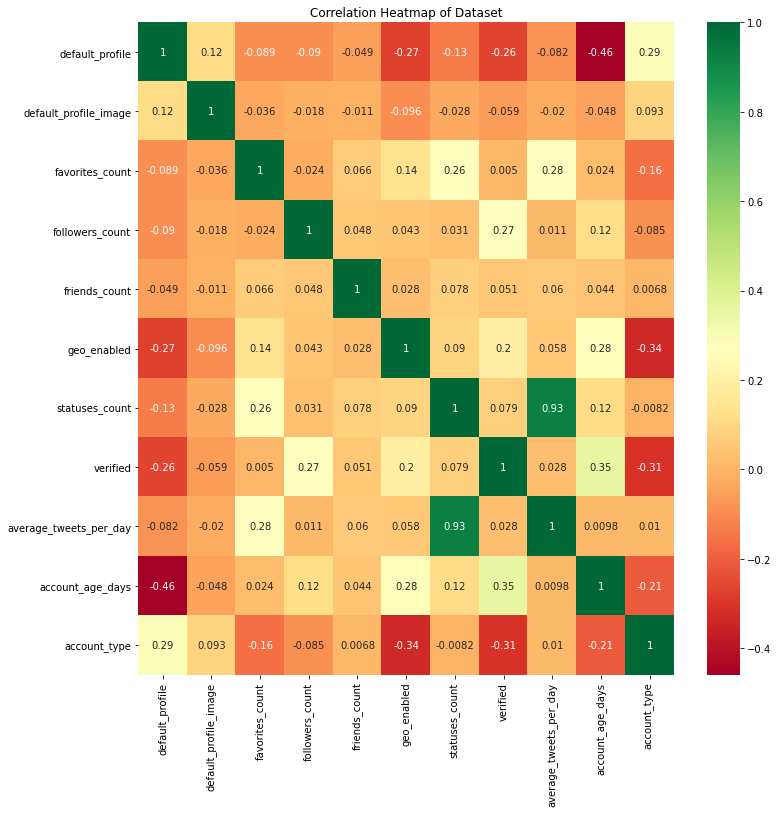

In [92]:
ax1 = plt.figure(figsize = (12, 12))
ax1 = sns.heatmap(df.corr(), cmap = "RdYlGn", annot = True)
plt.title("Correlation Heatmap of Dataset")

Due to the strong negative correlation between account_age_days and id, I will proceed to drop the id column as I do not think it provides much additional useful information. Additionally, id is meant to be an identifier anyway, so it lines up with when the account was created, but is less insightful than the actual number of days the account has been created (id is linear scale but account_age_days may not scale linearly with id, for example, if there were a surge of users signing up at one time) so that is why I would rather keep account_age_days. Additionally, I see strong positive correlation between statuses_count and average_tweets_per_day, which makes sense. As such, I will remove average_tweets_per_day to improve learning performance.

In [25]:
df.drop("id", axis = 1, inplace = True)
df.drop("average_tweets_per_day", axis = 1, inplace = True)
df

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,lang,location,statuses_count,verified,account_age_days,account_type
0,0,0,4,1589,4,0,en,unknown,11041,0,1403,1
1,0,0,536,860,880,0,en,Estados Unidos,252,0,1379,0
2,0,0,3307,172,594,1,en,"Los Angeles, CA",1001,0,1159,0
3,1,0,8433,517,633,1,en,"Birmingham, AL",1324,0,1489,0
4,0,0,88,753678,116,1,en,"England, United Kingdom",4202,1,3138,0
...,...,...,...,...,...,...,...,...,...,...,...,...
37433,1,0,651,139,1105,0,en,Kingston Upon Hull,340,0,4028,0
37434,0,0,8839,1121486,605,1,en,unknown,24970,1,2782,0
37435,1,0,399,85630,190,0,it,En constante movimiento,6174,1,2773,0
37436,0,0,967,138,166,1,en,"Los Angeles, CA",982,0,2899,0


We can also look at correlation heatmap for humans and bots individually, to explore if there are any interesting correlations within each group

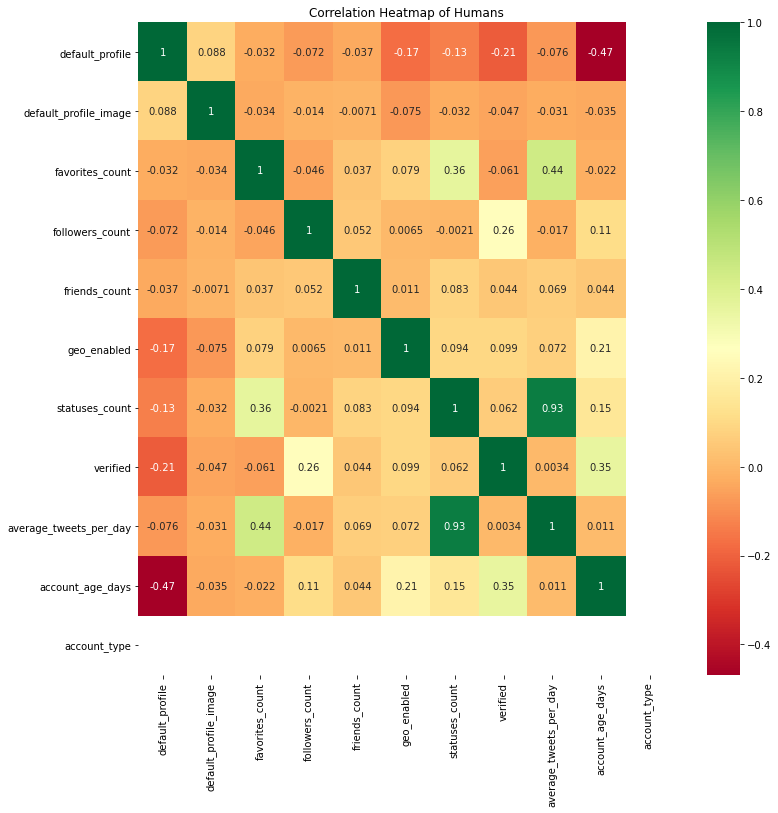

In [90]:
humans = df[df['account_type'] == 0]
ax2 = plt.figure(figsize = (12, 12))
ax2 = sns.heatmap(humans.corr(), cmap = "RdYlGn", annot = True)
plt.title("Correlation Heatmap of Humans")


Text(0.5, 1.0, 'Correlation Heatmap of Bots')

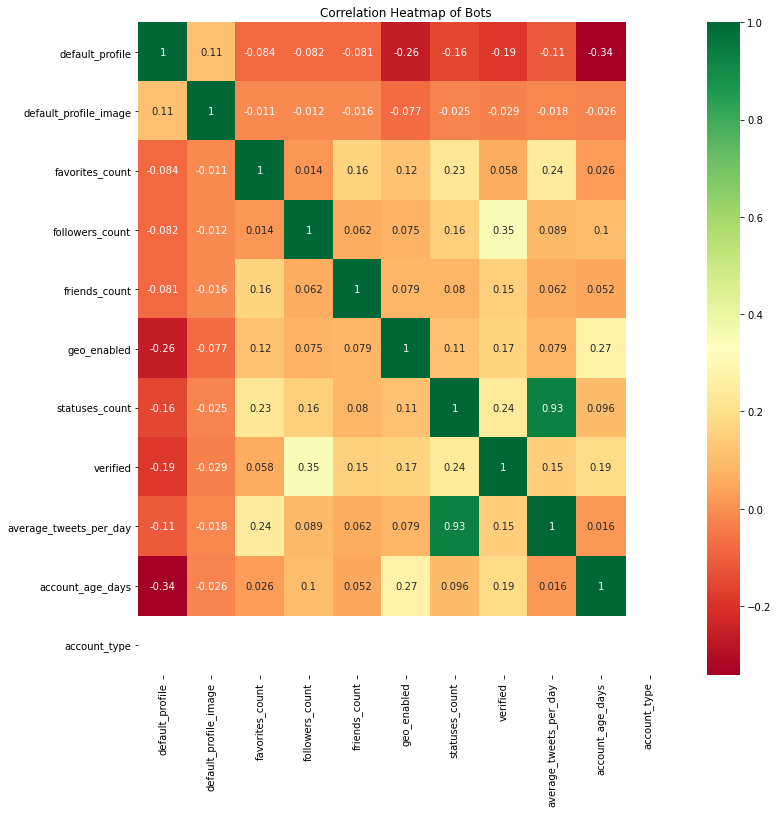

In [91]:
bots = df[df['account_type'] == 1]
ax3 = plt.figure(figsize = (12, 12))
ax3 = sns.heatmap(bots.corr(), cmap = "RdYlGn", annot = True)
plt.title("Correlation Heatmap of Bots")

Overall, the general trend in correlations is similar between humans and bots

Additionally, I am going to peform the one-hot encoding as mentioned earlier on the categorical features such as lang and location; before we do so, lets observe their values

In [65]:
lang_unique = pd.unique(df["lang"])
print(len(lang_unique))
lang_unique

49


array(['en', 'ar', 'None', 'so', 'it', 'es', 'fr', 'id', 'pt', 'ja',
       'zh-cn', 'de', 'lt', 'ru', 'tl', 'af', 'cy', 'tr', 'vi', 'ca',
       'no', 'hu', 'sw', 'ko', 'fa', 'el', 'sl', 'et', 'pl', 'fi', 'ro',
       'nl', 'da', 'sk', 'bg', 'sv', 'mk', 'hr', 'th', 'sq', 'cs', 'ur',
       'hi', 'lv', 'he', 'zh-tw', 'ne', 'uk', 'pa'], dtype=object)

In [66]:
location_unique = pd.unique(df["location"])
print(len(location_unique))
location_unique

12047


array(['unknown', 'Estados Unidos', 'Los Angeles, CA', ...,
       'Andheri West, Mumbai', 'Kingston Upon Hull',
       'En constante movimiento'], dtype=object)

We see there are many different values. Once these values become one hot encoded, the dataframe would become quite sparse and this could impact algorithm performance while increasing runtime. I am going to first drop these features as processing them may be time intensive, and potentially revist them. If revisited, these variables woud need to be summarized / encoded because they are sparse in general.

In [19]:
df_no_lang_location = df.drop(["lang", "location"], axis = 1)
df_no_lang_location

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,statuses_count,verified,account_age_days,account_type
0,0,0,4,1589,4,0,11041,0,1403,1
1,0,0,536,860,880,0,252,0,1379,0
2,0,0,3307,172,594,1,1001,0,1159,0
3,1,0,8433,517,633,1,1324,0,1489,0
4,0,0,88,753678,116,1,4202,1,3138,0
...,...,...,...,...,...,...,...,...,...,...
37433,1,0,651,139,1105,0,340,0,4028,0
37434,0,0,8839,1121486,605,1,24970,1,2782,0
37435,1,0,399,85630,190,0,6174,1,2773,0
37436,0,0,967,138,166,1,982,0,2899,0


In [67]:
# dummies_1 = pd.get_dummies(df["lang"])
# dummies_2 = pd.get_dummies(df["location"])

# #df = pd.concat([d`f, dummies_1, dummies_2], axis = 1)


Let's see how well different ML algorithms can learn on this data, just as an experiment. This would be a preliminary test to see how well different algorithms would perform; I am expecting better performance if I transformed data which I will do after.

In [197]:
X = df_no_lang_location.iloc[:, :-1]
y = df_no_lang_location["account_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(29925, 9)
(7482, 9)
(29925,)
(7482,)


In [198]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators= 100, random_state=0, class_weight = "balanced") # class_weight can be balanced using sklearn's built in balancing algorithm 
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

rf_probs = rf_classifier.predict_proba(X_test)
rf_probs = rf_probs[:, 1]


[[4703  289]
 [ 605 1885]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4992
           1       0.87      0.76      0.81      2490

    accuracy                           0.88      7482
   macro avg       0.88      0.85      0.86      7482
weighted avg       0.88      0.88      0.88      7482

0.8805132317562149


In [200]:
from sklearn.svm import SVC
svc_classifier = SVC(gamma="auto", probability=True)
svc_classifier.fit(X_train, y_train)
y_pred = svc_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

svm_probs = svc_classifier.predict_proba(X_test)
svm_probs = svm_probs[:, 1]

[[4992    0]
 [2392   98]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      4992
           1       1.00      0.04      0.08      2490

    accuracy                           0.68      7482
   macro avg       0.84      0.52      0.44      7482
weighted avg       0.78      0.68      0.56      7482

0.6802993851911253


In [202]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(penalty = "l1", solver = "saga", multi_class = "ovr", max_iter = 5000, class_weight= "balanced")
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

lr_probs = lr_classifier.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

[[4252  740]
 [1826  664]]
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      4992
           1       0.47      0.27      0.34      2490

    accuracy                           0.66      7482
   macro avg       0.59      0.56      0.55      7482
weighted avg       0.62      0.66      0.63      7482

0.657043571237637


In [203]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(n_estimators=100, learning_rate=1)
model = adaboost_classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

adaboost_probs = adaboost_classifier.predict_proba(X_test)
adaboost_probs= adaboost_probs[:, 1]

[[4498  494]
 [ 703 1787]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4992
           1       0.78      0.72      0.75      2490

    accuracy                           0.84      7482
   macro avg       0.82      0.81      0.82      7482
weighted avg       0.84      0.84      0.84      7482

0.8400160384923817


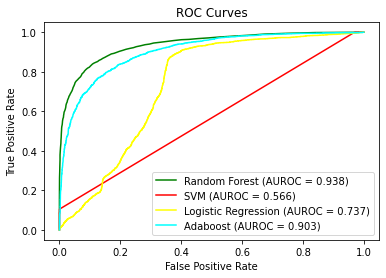

In [205]:
#r_auc = roc_auc_score(y_test, r_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
adaboost_auc = roc_auc_score(y_test, adaboost_probs)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
adaboost_fpr, adaboost_tpr, _ = roc_curve(y_test, adaboost_probs)

plt.plot(rf_fpr, rf_tpr, color = "green", label = "Random Forest (AUROC = %0.3f)" %rf_auc)
plt.plot(svm_fpr, svm_tpr, color = "red", label = "SVM (AUROC = %0.3f)" %svm_auc)
plt.plot(lr_fpr, lr_tpr, color = "yellow", label = "Logistic Regression (AUROC = %0.3f)" %lr_auc)
plt.plot(adaboost_fpr, adaboost_tpr, color = "cyan", label = "Adaboost (AUROC = %0.3f)" %adaboost_auc)

plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

Here, we see some very interesting results. It seems like the untransformed data doesn't have much impact on the random forest and Adaboost models, which perform quite well. On the other hand, we see other algorithms such as logistic regression and SVM really suffer from variables with high skew and variance.

I'm also curious about how the automated machine learning package tpot which has a lot of built in functionality, including feature rescaling (which is why I haven't rescaled / transformed any of the features yet) and pipeline selection will handle this untransformed data. 

In [107]:
tpot = TPOTClassifier(generations=50, population_size=100, verbosity=2, random_state=0, early_stop = 5)
tpot.fit(X_train, y_train)
y_pred = tpot.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

tpot_probs = tpot.predict_proba(X_test)
tpot_probs = tpot_probs[:, 1]
print(tpot_probs)

#Best pipeline: GradientBoostingClassifier(SGDClassifier(input_matrix, alpha=0.01, eta0=0.1, fit_intercept=False, l1_ratio=0.25, learning_rate=constant, loss=modified_huber, penalty=elasticnet, power_t=0.0), learning_rate=0.1, max_depth=8, max_features=0.55, min_samples_leaf=12, min_samples_split=20, n_estimators=100, subsample=0.8500000000000001)

Optimization Progress:   0%|          | 0/5100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8793120721322424

Generation 2 - Current best internal CV score: 0.8801803306061112

Generation 3 - Current best internal CV score: 0.8801803306061112

Generation 4 - Current best internal CV score: 0.8801803306061112

Generation 5 - Current best internal CV score: 0.8804474870596094

Generation 6 - Current best internal CV score: 0.8804474870596094


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(SGDClassifier(input_matrix, alpha=0.01, eta0=0.1, fit_intercept=False, l1_ratio=0.25, learning_rate=constant, loss=modified_huber, penalty=elasticnet, power_t=0.0), learning_rate=0.1, max_depth=8, max_features=0.55, min_samples_leaf=12, min_samples_split=20, n_estimators=100, subsample=0.8500000000000001)
[[4644  299]
 [ 621 1923]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      494

TypeError: can only concatenate str (not "numpy.float64") to str

Because tpot takes a long time to run, I decided to interrupt the process and take a look at the performance of the model, which appears to be quite decent without any feature transformations (ROC score was > 0.9 already). We can also learn from this preliminary model. First, we see the performance metrics in the classification report for the bot class to be lower than for the human class. This might be improved with by generating additional data for the bot class using the imbalanced-learn package, which I will explore below. Also, there don't appear to be any feature transformations in the pipeline generated, which I was expecting (although there could be some if I allowed the algorithm to run for longer). Thus, applying some feature transformations may improve model performance.

tpot AUC is 0.9379223859545993


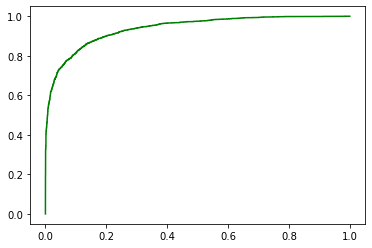

In [108]:
tpot_auc = roc_auc_score(y_test, tpot_probs)
print("tpot AUC is " + str(tpot_auc))

tpot_fpr, tpot_tpr, _ = roc_curve(y_test, tpot_probs)

plt.plot(tpot_fpr, tpot_tpr, color = "green", label = "tpot (AUROC = %0.3f)" %tpot_auc)

I'm going to start with the feature transformations. My plan is to standardize all the non-binary data so some features are not overweighted (especially in algorithms which use euclidean distance). Additionally, I will look into applying transfomrations such as log transform to data which are highly varied / skewed when appropriate so ML algorithms can have a better chance at picking up patterns and achiveve better performance. I will observe the distributions of each of the features first to determine if any transformations need to be applied. After, I will standardize all the features.

Text(0, 0.5, 'Density')

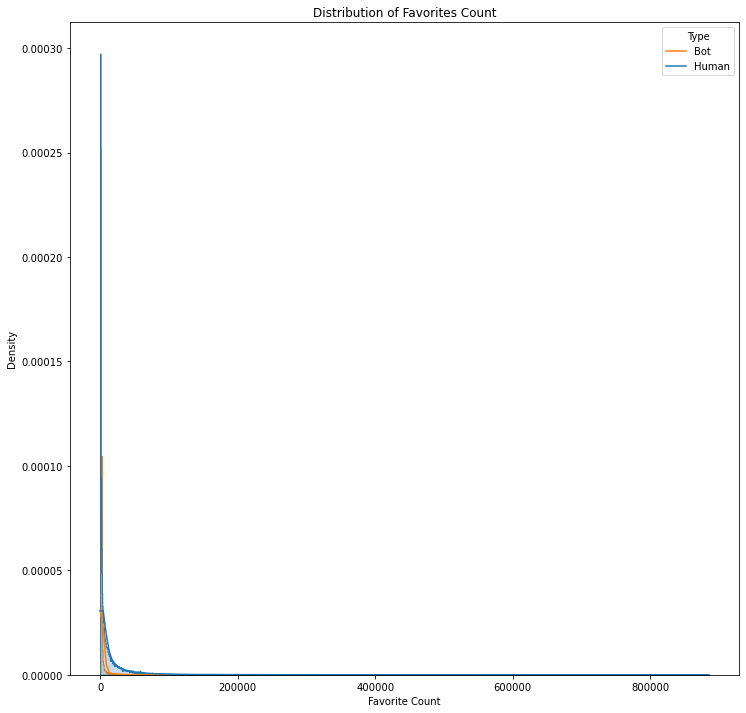

In [112]:
plt.figure(figsize=(12,12))
sns.histplot(x='favorites_count', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Favorites Count')
plt.xlabel('Favorite Count')
plt.ylabel('Density')

This looks like the perfect candidate for a log transform as the distribution is heavily right skewed. 

In [26]:
df['favorites_count_log'] = np.log(1 + df['favorites_count'])
df

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,lang,location,statuses_count,verified,account_age_days,account_type,favorites_count_log
0,0,0,4,1589,4,0,en,unknown,11041,0,1403,1,1.609438
1,0,0,536,860,880,0,en,Estados Unidos,252,0,1379,0,6.285998
2,0,0,3307,172,594,1,en,"Los Angeles, CA",1001,0,1159,0,8.104099
3,1,0,8433,517,633,1,en,"Birmingham, AL",1324,0,1489,0,9.040026
4,0,0,88,753678,116,1,en,"England, United Kingdom",4202,1,3138,0,4.488636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,1,0,651,139,1105,0,en,Kingston Upon Hull,340,0,4028,0,6.480045
37434,0,0,8839,1121486,605,1,en,unknown,24970,1,2782,0,9.087042
37435,1,0,399,85630,190,0,it,En constante movimiento,6174,1,2773,0,5.991465
37436,0,0,967,138,166,1,en,"Los Angeles, CA",982,0,2899,0,6.875232


Text(0, 0.5, 'Density')

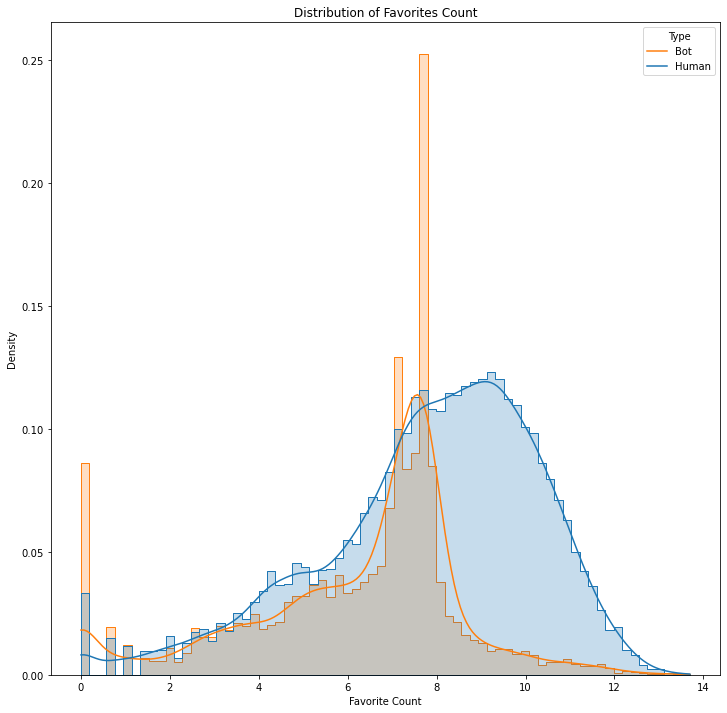

In [115]:
plt.figure(figsize=(12,12))
sns.histplot(x='favorites_count_log', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Logarithm of Favorites Count')
plt.xlabel('Favorite Count Logged')
plt.ylabel('Density')

The data looks much more spread out now, which is good. 

Text(0, 0.5, 'Density')

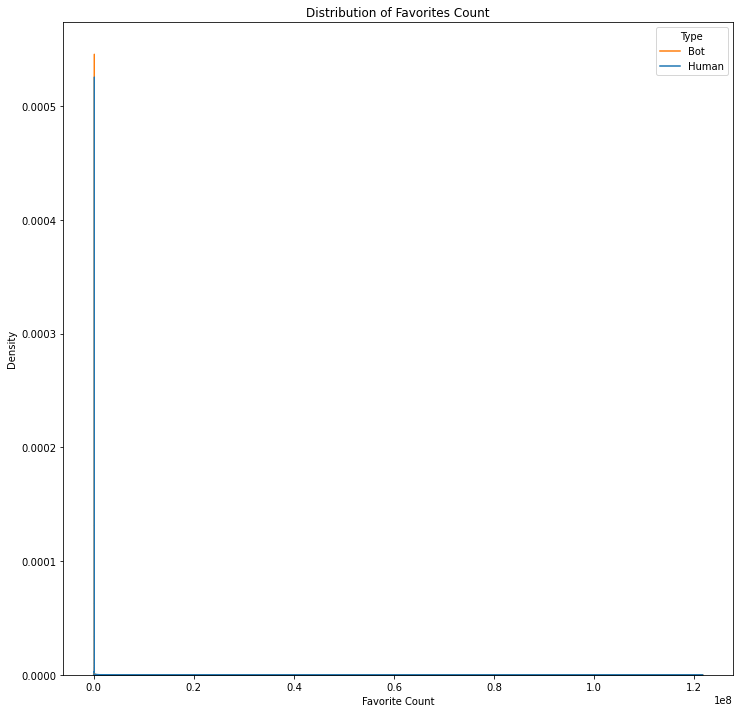

In [116]:
plt.figure(figsize=(12,12))
sns.histplot(x='followers_count', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Followers Count')
plt.xlabel('Followers Count')
plt.ylabel('Density')

Another great candidate for a log transform

In [27]:
df['followers_count_log'] = np.log(1 + df['followers_count'])


Text(0, 0.5, 'Density')

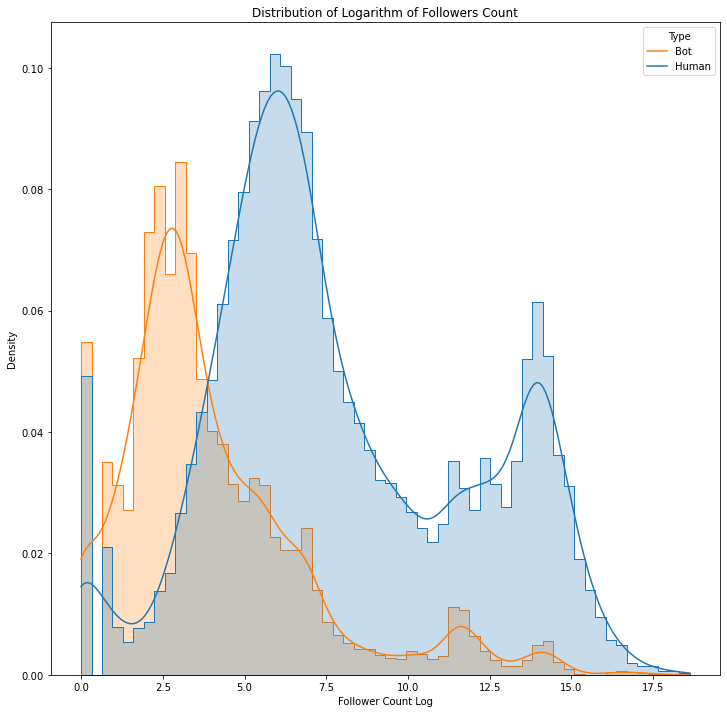

In [123]:
plt.figure(figsize=(12,12))
sns.histplot(x='followers_count_log', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Logarithm of Followers Count')
plt.xlabel('Follower Count Log')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

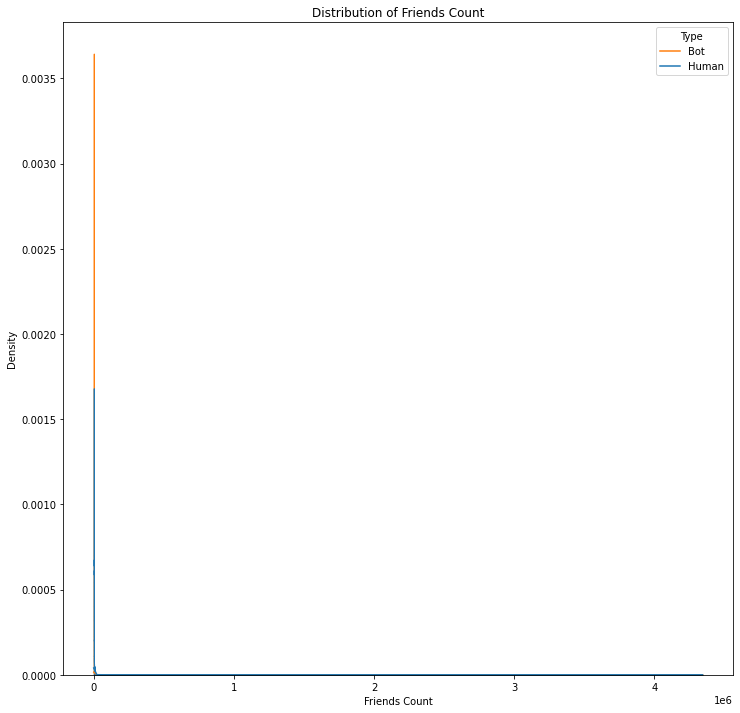

In [120]:
plt.figure(figsize=(12,12))
sns.histplot(x='friends_count', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Friends Count')
plt.xlabel('Friends Count')
plt.ylabel('Density')

Again, a good candidate for log transformation

In [28]:
df['friends_count_log'] = np.log(1 + df['friends_count'])

Text(0, 0.5, 'Density')

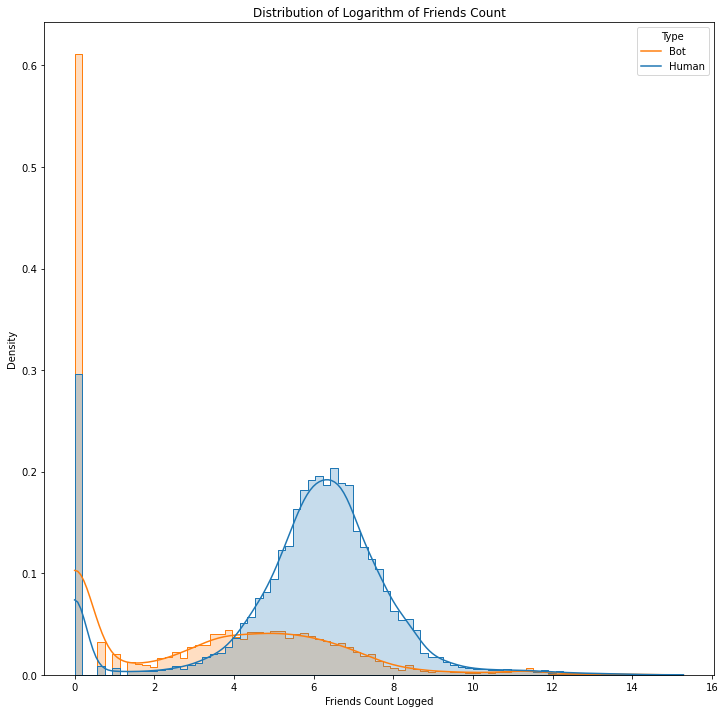

In [122]:
plt.figure(figsize=(12,12))
sns.histplot(x='friends_count_log', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Logarithm of Friends Count')
plt.xlabel('Friends Count Logged')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

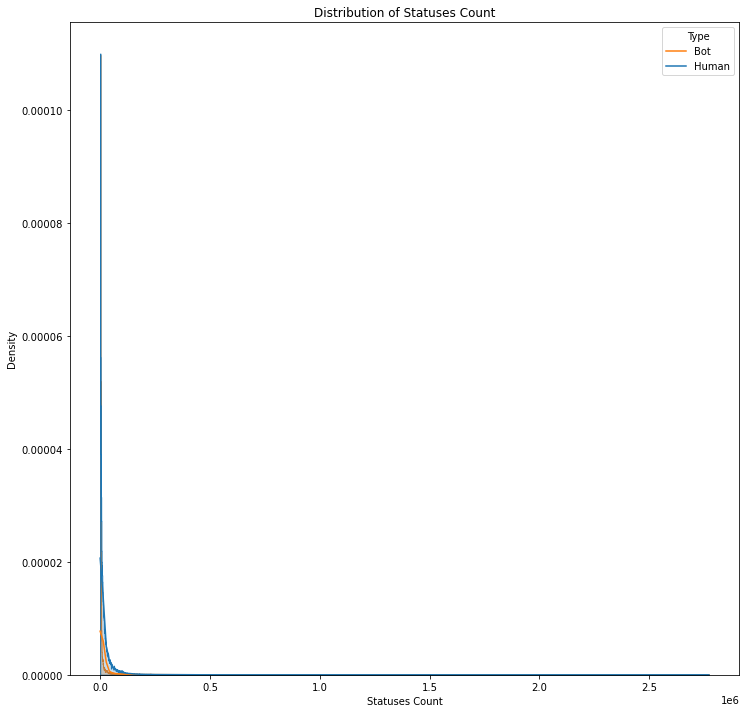

In [124]:
plt.figure(figsize=(12,12))
sns.histplot(x='statuses_count', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Statuses Count')
plt.xlabel('Statuses Count')
plt.ylabel('Density')

Let's log transform statuses count too since it is severely right skewed

In [29]:
df['statuses_count_log'] = np.log(1 + df['statuses_count'])

Text(0, 0.5, 'Density')

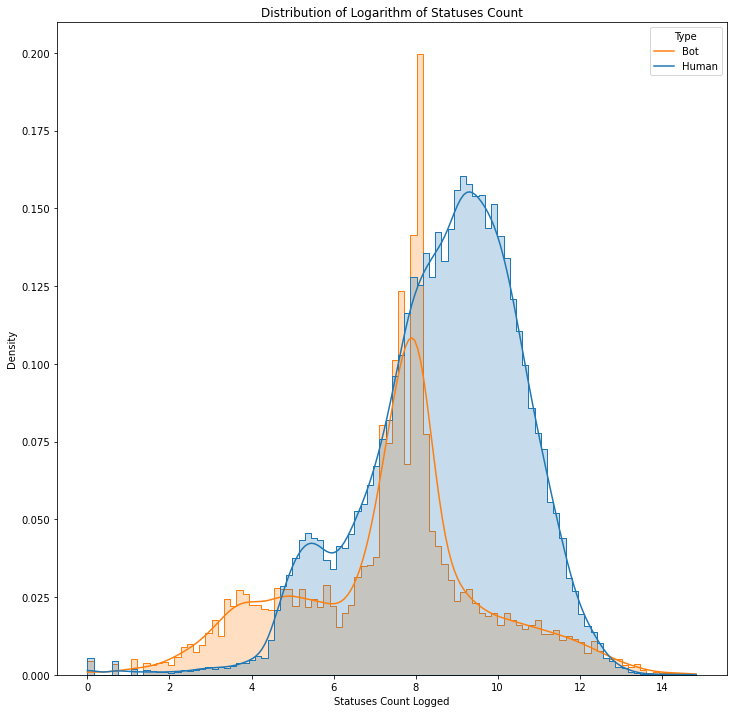

In [126]:
plt.figure(figsize=(12,12))
sns.histplot(x='statuses_count_log', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Logarithm of Statuses Count')
plt.xlabel('Statuses Count Logged')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

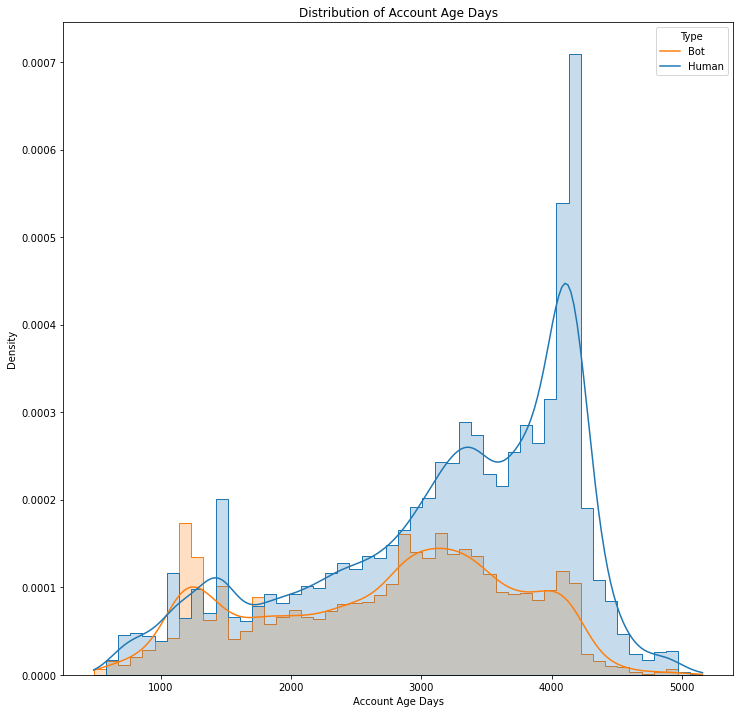

In [128]:
plt.figure(figsize=(12,12))
sns.histplot(x='account_age_days', data=df, hue='account_type', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Type', labels=['Bot', 'Human'])
plt.title('Distribution of Account Age Days')
plt.xlabel('Account Age Days')
plt.ylabel('Density')

We observe a left skew for the distribution of human account ages, and a flatter distribution for the distribution of bot account ages. I'm going to leave this feature as is, because a log transform would not help left-skewed data (in fact it would make it worse), and any other transformation could potentially alter the relatively flat distribution of bots ages. In short, there aren't any beneficial transformations which could be applied to this feature that I know of. 

Now we are going to standardize the data, but before we do that, we have to create training and testing sets to avoid any data leakage. I am going to use MinMaxScaler since we do not have the assumption that the features are normally distributed and we want to keep the distribtion shape.

In [42]:
df_transformed = df.drop(["favorites_count", "followers_count", "friends_count", "statuses_count"], axis = 1)
df_transformed.drop(["lang", "location"], axis = 1, inplace = True)
col = df_transformed.pop("account_type")
df_transformed["account_type"] = col
df_transformed

,default_profile,default_profile_image,geo_enabled,verified,account_age_days,favorites_count_log,followers_count_log,friends_count_log,statuses_count_log,account_type
0,0,0,0,0,1403,1.609438,7.371489,1.609438,9.309461,1
1,0,0,0,0,1379,6.285998,6.758095,6.781058,5.533389,0
2,0,0,1,0,1159,8.104099,5.153292,6.388561,6.909753,0
3,1,0,1,0,1489,9.040026,6.249975,6.452049,7.189168,0
4,0,0,1,1,3138,4.488636,13.532722,4.762174,8.343554,0
...,...,...,...,...,...,...,...,...,...,...
37433,1,0,0,0,4028,6.480045,4.941642,7.008505,5.831882,0
37434,0,0,1,1,2782,9.087042,13.930166,6.406880,10.125470,0
37435,1,0,0,1,2773,5.991465,11.357803,5.252273,8.728264,0
37436,0,0,1,0,2899,6.875232,4.934474,5.117994,6.890609,0


In [45]:
X = df_transformed.iloc[:, :-1]
y = df_transformed["account_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [46]:
scaler = MinMaxScaler()
MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[1.        , 0.        , 1.        , ..., 0.79243749, 0.43058562,
        0.60048029],
       [0.        , 0.        , 1.        , ..., 0.75266017, 0.48279695,
        0.6891649 ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.27340437,
        0.35079137],
       ...,
       [0.        , 0.        , 0.        , ..., 0.15591933, 0.26674478,
        0.49301405],
       [0.        , 0.        , 1.        , ..., 0.37082441, 0.5721913 ,
        0.74466475],
       [0.        , 0.        , 0.        , ..., 0.15283595, 0.        ,
        0.49574242]])

Let's try some standard algorithms for classification first

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators= 100, random_state=0, class_weight = "balanced") # class_weight can be balanced using sklearn's built in balancing algorithm 
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

rf_probs = rf_classifier.predict_proba(X_test)
rf_probs = rf_probs[:, 1]


[[4687  256]
 [ 654 1890]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4943
           1       0.88      0.74      0.81      2544

    accuracy                           0.88      7487
   macro avg       0.88      0.85      0.86      7487
weighted avg       0.88      0.88      0.88      7487

0.8784559903833311


In [50]:
from sklearn.svm import SVC
svc_classifier = SVC(gamma="auto", probability=True)
svc_classifier.fit(X_train, y_train)
y_pred = svc_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

svm_probs = svc_classifier.predict_proba(X_test)
svm_probs = svm_probs[:, 1]

[[4404  539]
 [ 932 1612]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4943
           1       0.75      0.63      0.69      2544

    accuracy                           0.80      7487
   macro avg       0.79      0.76      0.77      7487
weighted avg       0.80      0.80      0.80      7487

0.8035261119273407


In [212]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(penalty = "l1", solver = "saga", multi_class = "ovr", max_iter = 2000, class_weight= "balanced")
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

lr_probs = lr_classifier.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

[[3811 1132]
 [ 497 2047]]
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4943
           1       0.64      0.80      0.72      2544

    accuracy                           0.78      7487
   macro avg       0.76      0.79      0.77      7487
weighted avg       0.80      0.78      0.79      7487

0.7824228663015894


In [213]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(n_estimators=100, learning_rate=1)
model = adaboost_classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

adaboost_probs = adaboost_classifier.predict_proba(X_test)
adaboost_probs= adaboost_probs[:, 1]

[[4496  447]
 [ 759 1785]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4943
           1       0.80      0.70      0.75      2544

    accuracy                           0.84      7487
   macro avg       0.83      0.81      0.81      7487
weighted avg       0.84      0.84      0.84      7487

0.8389207960464806


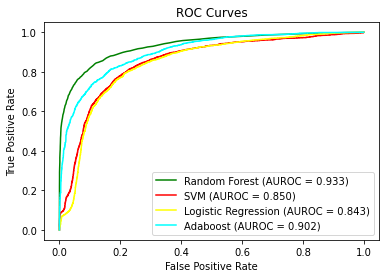

In [214]:
#r_auc = roc_auc_score(y_test, r_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
adaboost_auc = roc_auc_score(y_test, adaboost_probs)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
adaboost_fpr, adaboost_tpr, _ = roc_curve(y_test, adaboost_probs)

plt.plot(rf_fpr, rf_tpr, color = "green", label = "Random Forest (AUROC = %0.3f)" %rf_auc)
plt.plot(svm_fpr, svm_tpr, color = "red", label = "SVM (AUROC = %0.3f)" %svm_auc)
plt.plot(lr_fpr, lr_tpr, color = "yellow", label = "Logistic Regression (AUROC = %0.3f)" %lr_auc)
plt.plot(adaboost_fpr, adaboost_tpr, color = "cyan", label = "Adaboost (AUROC = %0.3f)" %adaboost_auc)

plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

Looking at the performance for the scikitlearn algorithms, it appears the logistic regression and svm models show much better performance after the data transformations. However, the random forest and adaboost models perform virtually identically as before. This makes sense because random forest and adaboost are tree based classification algorithms which are not affected by the absolute value a feature takes. We also see lower performance metrics for the most part for bots, which suggests balancing the data using a package such as imbalanced-learn may be beneficial (over the built in balancing techniques in some of the sklearn algorithms), although we will have to see if this is the case.

In [58]:
tpot = TPOTClassifier(generations=50, population_size=100, verbosity=2, random_state=0, early_stop = 5, scoring = "roc_auc")
tpot.fit(X_train, y_train)
y_pred = tpot.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

tpot_probs = tpot.predict_proba(X_test)
tpot_probs = tpot_probs[:, 1]
print(tpot_probs)

Optimization Progress:   0%|          | 0/5100 [00:00<?, ?pipeline/s]



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=10, max_features=0.6500000000000001, min_samples_leaf=19, min_samples_split=16, n_estimators=100, subsample=0.55), bootstrap=True, criterion=gini, max_features=0.25, min_samples_leaf=14, min_samples_split=18, n_estimators=100)
[[4668  275]
 [ 678 1866]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      4943
           1       0.87      0.73      0.80      2544

    accuracy                           0.87      7487
   macro avg       0.87      0.84      0.85      7487
weighted avg       0.87      0.87      0.87      7487

0.8727127020168292
[0.51084037 0.01321737 0.99578945 ... 0.04188348 0.16125745 0.00576374]


tpot AUC is 0.9349062011331697


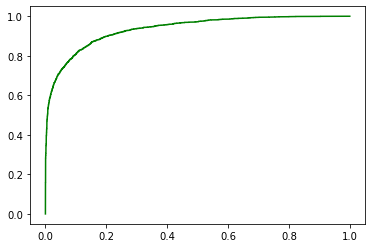

In [59]:
tpot_auc = roc_auc_score(y_test, tpot_probs)
print("tpot AUC is " + str(tpot_auc))

tpot_fpr, tpot_tpr, _ = roc_curve(y_test, tpot_probs)

plt.plot(tpot_fpr, tpot_tpr, color = "green", label = "tpot (AUROC = %0.3f)" %tpot_auc)

I am highly interested in the proportion of bots to humans. There should be more humans if this was a random sample. If the proportion is unbalanced, we can use a package such as imbalanced-learn to impute samples

In [68]:

df["account_type"].value_counts()

0    25013
1    12419
Name: account_type, dtype: int64

It appears there's roughly twice as many humans as bots. We will use imbalanced-learn after looking at some of the other features.

Lets apply the imbalanced-learn package to create a balanced dataset. A balanced dataset is ideal because the learning phase and the subsequent prediction of machine learning algorithms can be affected by the problem of imbalanced data set. Although the dataset is not highly unbalanced, it would be interesting to observe the different results between balanced and unbalanced datasets.

In [216]:
sme = SMOTETomek(random_state=0)
X_train, y_train = sme.fit_resample(X_train, y_train)


In [217]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators= 100, random_state=0, class_weight = "balanced") # class_weight can be balanced using sklearn's built in balancing algorithm 
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

rf_probs = rf_classifier.predict_proba(X_test)
rf_probs = rf_probs[:, 1]


[[4488  455]
 [ 511 2033]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4943
           1       0.82      0.80      0.81      2544

    accuracy                           0.87      7487
   macro avg       0.86      0.85      0.86      7487
weighted avg       0.87      0.87      0.87      7487

0.8709763590223053


In [218]:
from sklearn.svm import SVC
svc_classifier = SVC(gamma="auto", probability=True)
svc_classifier.fit(X_train, y_train)
y_pred = svc_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

svm_probs = svc_classifier.predict_proba(X_test)
svm_probs = svm_probs[:, 1]

[[3877 1066]
 [ 500 2044]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      4943
           1       0.66      0.80      0.72      2544

    accuracy                           0.79      7487
   macro avg       0.77      0.79      0.78      7487
weighted avg       0.81      0.79      0.79      7487

0.7908374515827434


In [219]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(penalty = "l1", solver = "saga", multi_class = "ovr", max_iter = 2000, class_weight= "balanced")
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

lr_probs = lr_classifier.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

[[3814 1129]
 [ 504 2040]]
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4943
           1       0.64      0.80      0.71      2544

    accuracy                           0.78      7487
   macro avg       0.76      0.79      0.77      7487
weighted avg       0.80      0.78      0.79      7487

0.781888606918659


In [220]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(n_estimators=100, learning_rate=1)
model = adaboost_classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

adaboost_probs = adaboost_classifier.predict_proba(X_test)
adaboost_probs= adaboost_probs[:, 1]

[[4124  819]
 [ 495 2049]]
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4943
           1       0.71      0.81      0.76      2544

    accuracy                           0.82      7487
   macro avg       0.80      0.82      0.81      7487
weighted avg       0.83      0.82      0.83      7487

0.8244957927073594


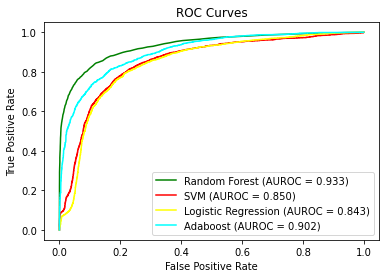

In [214]:
#r_auc = roc_auc_score(y_test, r_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
adaboost_auc = roc_auc_score(y_test, adaboost_probs)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
adaboost_fpr, adaboost_tpr, _ = roc_curve(y_test, adaboost_probs)

plt.plot(rf_fpr, rf_tpr, color = "green", label = "Random Forest (AUROC = %0.3f)" %rf_auc)
plt.plot(svm_fpr, svm_tpr, color = "red", label = "SVM (AUROC = %0.3f)" %svm_auc)
plt.plot(lr_fpr, lr_tpr, color = "yellow", label = "Logistic Regression (AUROC = %0.3f)" %lr_auc)
plt.plot(adaboost_fpr, adaboost_tpr, color = "cyan", label = "Adaboost (AUROC = %0.3f)" %adaboost_auc)

plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

These results look quite similar to the ones without balancing the data, but thats probably due to some of the algorithms already performing balancing within before (as I turned this functionality on), and also because the dataset is not too badly imbalanced.

In [153]:
tpot = TPOTClassifier(generations=50, population_size=100, verbosity=2, random_state=0, early_stop = 5, scoring = "roc_auc")
tpot.fit(X_train, y_train)
y_pred = tpot.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

tpot_probs = tpot.predict_proba(X_test)
tpot_probs = tpot_probs[:, 1]
print(tpot_probs)

Optimization Progress:   0%|          | 0/5100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9755746601883765

Generation 2 - Current best internal CV score: 0.9755746601883765

Generation 3 - Current best internal CV score: 0.976454843008659

Generation 4 - Current best internal CV score: 0.976454843008659

Generation 5 - Current best internal CV score: 0.9766147796786603

Generation 6 - Current best internal CV score: 0.9766727435001249

Generation 7 - Current best internal CV score: 0.9766727435001249

Generation 8 - Current best internal CV score: 0.9768605113593821

Generation 9 - Current best internal CV score: 0.9770221870842978


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(CombineDFs(input_matrix, RBFSampler(PCA(input_matrix, iterated_power=1, svd_solver=randomized), gamma=0.7000000000000001)), bootstrap=False, criterion=entropy, max_features=0.55, min_samples_leaf=2, min_samples_split=7, n_estimators=100)
[[1968  57

tpot AUC is 0.9253861553152479


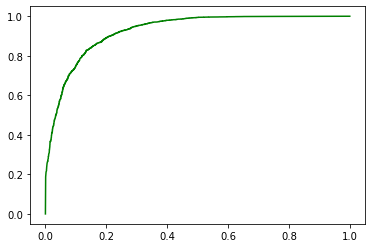

In [159]:
tpot_auc = roc_auc_score(y_test, tpot_probs)
print("tpot AUC is " + str(tpot_auc))

tpot_fpr, tpot_tpr, _ = roc_curve(y_test, tpot_probs)

plt.plot(tpot_fpr, tpot_tpr, color = "green", label = "tpot (AUROC = %0.3f)" %tpot_auc)

## Analysis and Next Steps

Overall, we observe some very interesting results. It appears tpot and random forest performs well across the board, with AUROC > 0.9, as well as good precision and recall scores (both > ~0.9 for humans and > ~0.8 for bots). This means there are relatively few false postives and false negatives. Accuracy is not bad either, with a prediction being correct ~ > 85% of the time for top performing models. Interestingly, the performance metrics (i.e. precision, recall, accuracy, f1) are lower most of the time for bots compared to humans, even after different balancing techniques were applied (such as built in balancing done by some sklearn algorithms such as random forest, or through external packages such as imbalanced learn). This could because data relevant to some bots was underrepresented (by chance) and collecting more data on bot profiles can help alleviate this. It could also be the interpolation strategies used by imbalanced learn create noise and do not help genereate underrepresented profiles (this might be alleviated with different resampling techniques, which is something worth investigating if I had more time). If I were to choose a model to use for the absolute best performance, I would place my bets on tpot (especially the pipeline it generates after running completely) since it does a lot of the tuning under the hood; it also generates a pipeline, which may capture nuances a simpler model can not. Also, tpot was one of the top performing models and applying it to the data at various stages of transformation while still delivering robust results speaks to the efficiency of the algorithm. However, random forest suprised me in how well it performed, and for practial purposes, it would probably be the better model to use since its less computationally intensive than an entire pipeline, and also has fewer hyperparmaters to tune.

I mentioned a few things I would work on as next steps above, but to build on that, I think I would like to first let tpot run for longer. tpot is meant to run for hours and even days so it can find the best algorithm, and that may be an easy way to boost performance without even further modifying the data. Additionally, I would investigate the features I dropped, especially as they may pack information useful for classification, and I intended to do this, however I contracted COVID and had to spend some time recovering. Last but not least, I was also going to do some hyperparameter tuning for promising models such as random forest, and that would also improve performance of the model.